In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread, imresize
import scipy.io as sio
import matplotlib.pylab as plt
from scipy.ndimage import uniform_filter
import seaborn as sns
import bokeh.io
import bokeh.mpl
import bokeh.plotting
from six.moves import cPickle as pickle
import time
import hashlib
from PIL import Image, ImageFilter
import random
import cv2
from skimage.transform import resize
from glob import glob

%load_ext autoreload
%autoreload 1
%matplotlib inline
%config InlineBackend.figure_formats = {'jpg', 'retina'}

# Plotting parameters

In [2]:
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 10, 
      'axes.titlesize': 10, 
      'axes.facecolor': 'DFDFE5',
      'axes.linecolor': 'white'}

sns.set_context('notebook', rc=rc)
sns.set_style('whitegrid', rc=rc)
bokeh.io.output_notebook()

Loading BokehJS ...

# Check for data

In [3]:
# Make sure you have the data, if not check out notebooks/readme.md
assert(os.path.exists("../svhn/raw/train.pickle"))
assert(os.path.exists("../svhn/raw/test.pickle"))
assert(os.path.exists("../svhn/raw/extra.pickle"))
print("Got the data we need!")

Got the data we need!


# Helper functions to load, extract, and analyze the data

In [4]:
def load_pickle(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
        return data
    
def extract_data(data, name):
    imsize = np.ndarray([len(data),2])
    digits = [0]*6
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join("../svhn/{}/{}".format(name, filename))
        im = Image.open(fullname)
        imsize[i, :] = im.size[:]

        boxes = data[i]['boxes']
        num_digits = len(boxes)
        if num_digits>5:
            digits[5] += 1
        else:
            digits[num_digits-1] += 1
            
    return imsize, digits

def digts_percent(num_digits):
    percent_digits = np.array([0, 0, 0, 0, 0, 0], dtype=float)
    np.true_divide(np.multiply(num_digits,100),np.sum(num_digits), percent_digits)
    return percent_digits

# Load the data

In [5]:
test = load_pickle("../svhn/raw/test.pickle")
train = load_pickle("../svhn/raw/train.pickle")
extra = load_pickle("../svhn/raw/extra.pickle")

# Extract Digits

In [6]:
train_imsize, train_num_digits = extract_data(train, "train")
test_imsize, test_num_digits = extract_data(test, "test")
extra_imsize, extra_num_digits = extract_data(extra, "extra")

# Image Stats

In [7]:
from IPython.display import display, Image

d = {'Max. Height' : pd.Series([np.amax(train_imsize[:,1]), np.amax(test_imsize[:,1]), np.amax(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Min. Height' : pd.Series([np.amin(train_imsize[:,1]), np.amin(test_imsize[:,1]), np.amin(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Avg. Height' : pd.Series([np.mean(train_imsize[:,1]), np.mean(test_imsize[:,1]), np.mean(extra_imsize[:,1])], index=['Training', 'Testing', 'Extra']),
     'Max. Width' : pd.Series([np.amax(train_imsize[:,0]), np.amax(test_imsize[:,0]), np.amax(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra']),
     'Min. Width' : pd.Series([np.amin(train_imsize[:,0]), np.amin(test_imsize[:,0]), np.amin(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra']),
     'Avg. Width' : pd.Series([np.mean(train_imsize[:,0]), np.mean(test_imsize[:,0]), np.mean(extra_imsize[:,0])], index=['Training', 'Testing', 'Extra'])}

df = pd.DataFrame(d)

display(df.T)

,Training,Testing,Extra
Avg. Height,57.213011,71.566498,60.800151
Avg. Width,128.284983,172.583486,100.389250
Max. Height,501.000000,516.000000,415.000000
Max. Width,876.000000,1083.000000,668.000000
Min. Height,12.000000,13.000000,13.000000
Min. Width,25.000000,31.000000,22.000000


# Sequence Stats

In [9]:
train_percent = digts_percent(train_num_digits)
test_percent = digts_percent(test_num_digits)
extra_percent = digts_percent(extra_num_digits)

# 5 is 5 or more digits present in image
df_percent = pd.DataFrame({"train": train_percent, "test": test_percent, "extra": extra_percent})
df_percent

,extra,test,train
0,4.637935,19.000612,15.379319
1,35.445978,63.942455,54.278187
2,52.773618,15.924395,26.019400
3,7.085637,1.117233,4.293156
4,0.056831,0.015305,0.026944
5,0.000000,0.000000,0.002994


# Plot raw images

In [10]:
train_files = [f for f in glob("../svhn/train/*")]

In [29]:
def plot_images(files):
    ith = 0
    plt.rcParams['figure.figsize'] = (4.0, 4.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    for img in files[16:32]:
        img = imread(img)
        img = cv2.resize(img, (64, 64))
        plt.subplot(4, 4, ith+1)
        plt.imshow(img);
        plt.axis('off')
        ith += 1
    plt.show()

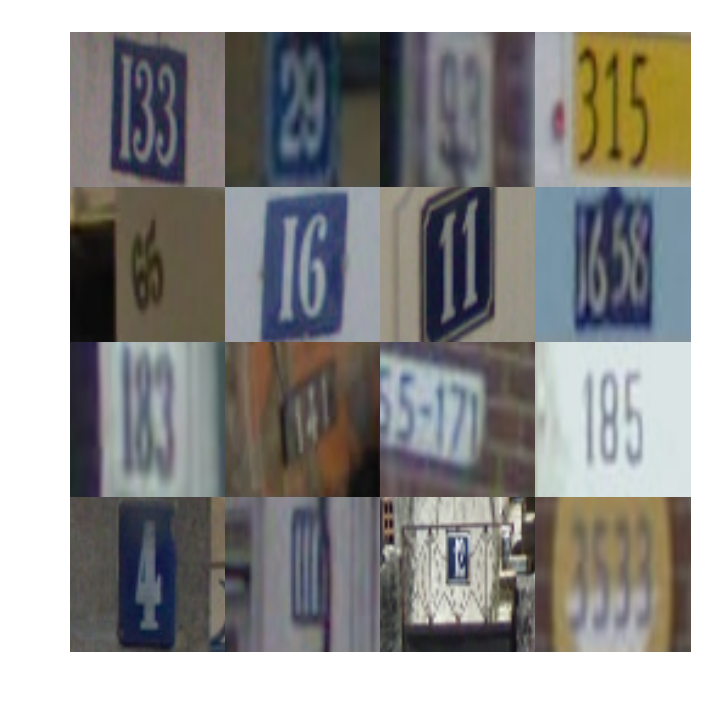

In [30]:
plot_images(train_files)